# Hierarchical Attention Network for Document Classification


# Import libraries


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#import pip
#import theano
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model, register_keras_serializable
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import SGD



[nltk_data] Downloading package punkt to /Users/lanado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lanado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set the logging level to ERROR to suppress warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Additionally, suppress other warnings if needed
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:
import gensim

In [4]:
from gensim.models import KeyedVectors

# Functions

In [5]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split=0.8, validation_split=0.2):
    if training_split + validation_split != 1.0:
        raise ValueError('Split parameter sum should be 1.0')

    # Shuffle and split the data
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
        .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    validation = dataframe.drop(train.index).sample(frac=1)

    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))

    return train, validation


def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data


def to_categorical(series, n_classes=5):
    # Initialize an array of zeros with the shape (number of samples, number of classes)
    y_cat = np.zeros((len(series), n_classes))
    
    # Set the appropriate element to 1
    y_cat[np.arange(len(series)), series] = 1
    
    return y_cat


# Attention layer

In [12]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class AttentionLayer(Layer):
    """
    Hierarchical Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    TensorFlow backend
    """
    def __init__(self, attention_dim=100, return_coefficients=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        self.attention_dim = attention_dim

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], self.attention_dim),
                                 initializer=self.init,
                                 name='W')
        self.b = self.add_weight(shape=(self.attention_dim,),
                                 initializer=self.init,
                                 name='b')
        self.u = self.add_weight(shape=(self.attention_dim, 1),
                                 initializer=self.init,
                                 name='u')
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs, mask=None):
        hit = inputs
        uit = K.bias_add(K.dot(hit, self.W), self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, axis=-1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
        
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({
            "attention_dim": self.attention_dim,
            "return_coefficients": self.return_coefficients
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [36]:
splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])

In [8]:
df_test = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

In [9]:
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [10]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(df.shape[0]):
    sent = tokenize.sent_tokenize(df.loc[i,'text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/df.shape[0]))

Average number of words in each sentence:  18
Average number of sentences in each document:  9


# Parameters

In [11]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 300      # vector size of word embedding

# Data Preprocessing

In [12]:

def clean_articles(dataframe):
    articles = []
    n = dataframe.shape[0]
    col_number = dataframe.columns.get_loc('text')
    stopWords = set(stopwords.words('english'))
    data_cleaned = dataframe.copy()

    for i in range(n):
        temp_string, idx_string = cleanString(dataframe.iloc[i, col_number], stopWords)
        articles.append(temp_string)
        print(str(i+1) + ' of ' + str(n) + " articles cleaned.", end='\r')

    data_cleaned.loc[:, 'text'] = pd.Series(articles, index=dataframe.index)
    return data_cleaned



In [13]:
data_cleaned = clean_articles(df)

In [14]:
data_cleaned_test = clean_articles(df_test)

In [15]:
data_cleaned.head()

,label,text
0,4,goldberg offer everything look general practit...
1,1,unfortunately frustration goldberg patient rep...
2,3,going goldberg 10 year . think one 1st patient...
3,3,got letter mail last week said goldberg moving...
4,0,know goldberg like moving arizona let tell sta...


# Tokenization

In [16]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
def tokenization(data):
    texts = []
    n = data['text'].shape[0]
    for i in range(n):
        s = data['text'].iloc[i]
        s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) != ""])
        texts.append(s)
    tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    return tokenizer, word_index

tokenizer, word_index = tokenization(data_cleaned)
#val_tokenizer, val_word_index = tokenization(data_cleaned_val)

# Word2Vec Embedding

In [17]:
# Load Word2Vec embeddings
def embedding_word2Vec(tokenizer, word_index, path_to_word2vec):
    # Load the Word2Vec model (binary format)
    word2vec_model = KeyedVectors.load_word2vec_format(path_to_word2vec, binary=True)
    
    print('Word2Vec model loaded.')

    # Search words in our word index in the pre-trained Word2Vec model
    min_wordCount = 2
    absent_words = 0
    small_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    word_counts = tokenizer.word_counts
    
    for word, i in word_index.items():
        if word_counts[word] > min_wordCount:
            if word in word2vec_model:
                embedding_matrix[i] = word2vec_model[word]
            else:
                absent_words += 1
        else:
            small_words += 1
    
    print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
          '% of total words')
    print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
          '% of total words')
    
    return embedding_matrix

# Path to the downloaded Word2Vec binary file
path_to_word2vec = 'GoogleNews-vectors-negative300.bin'
embedding_matrix_word2vec = embedding_word2Vec(tokenizer, word_index, path_to_word2vec)


Word2Vec model loaded.
Total absent words are 26516 which is 14.12 % of total words
Words with 2 or less mentions 113492 which is 60.44 % of total words


# Splitting Data Set

In [18]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
#print(categoryToCode)

train, validation= split_df(data_cleaned, 'label',0.8,0.2)
from tensorflow.keras.utils import to_categorical
#Training
paras = []
for i in range(data_cleaned['text'].shape[0]):
    sequence = wordToSeq(df['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
num_classes = 5
y_train = to_categorical(data_cleaned['label'],num_classes)

#Validation
paras = []
for i in range(validation['text'].shape[0]):
    sequence = wordToSeq(validation['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['label'],num_classes)



/var/folders/pn/jrl8dp3x15nfyh50_q0l49km0000gn/T/ipykernel_55755/2502587804.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\


Total:  650000
Training:  520000 , Percentage:  0.8
Validation:  130000 , Percentage:  0.2


In [19]:
#Test
paras = []
for i in range(data_cleaned_test['text'].shape[0]):
    sequence = wordToSeq(df_test['text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
num_classes = 5
y_test = to_categorical(data_cleaned_test['label'],num_classes)

In [20]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

# HAN MODEL

In [21]:
def build_model(hp):
    # Create Keras functional model for hierarchical attention network
    embedding_layer = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix_word2vec], 
                                input_length=MAX_WORD_NUM, trainable=False, name='word_embedding')

    # Words level attention model
    word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32', name='word_input')
    word_sequences = embedding_layer(word_input)
    word_gru = Bidirectional(GRU(50, return_sequences=True), name='word_gru')(word_sequences)
    word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
    word_att, word_coeffs = AttentionLayer(EMBED_SIZE, True, name='word_attention')(word_dense)
    wordEncoder = Model(inputs=word_input, outputs=word_att)

    # Sentence level attention model
    sent_input = Input(shape=(MAX_SENTENCE_NUM, MAX_WORD_NUM), dtype='int32', name='sent_input')
    sent_encoder = TimeDistributed(wordEncoder, name='sent_linking')(sent_input)
    sent_gru = Bidirectional(GRU(50, return_sequences=True), name='sent_gru')(sent_encoder)
    sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
    sent_att, sent_coeffs = AttentionLayer(EMBED_SIZE, return_coefficients=True, name='sent_attention')(sent_dense)
    sent_drop = Dropout(0.5, name='sent_dropout')(sent_att)
    preds = Dense(5, activation='softmax', name='output')(sent_drop)

    # Define optimizer with learning rate as a hyperparameter
    optimizer = SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG'), 
                    momentum=0.9)
    
    # Compile the model
    model = Model(sent_input, preds)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [22]:
from sklearn.model_selection import train_test_split

# Sample 80,000 samples from the original training set
x_train_sampled, _, y_train_sampled, _ = train_test_split(
    x_train, y_train, 
    train_size=80000,  
    stratify=y_train,  
    random_state=42  
)

# Sample 20,000 samples from the original validation set
x_val_sampled, _, y_val_sampled, _ = train_test_split(
    x_val, y_val, 
    train_size=20000,  
    stratify=y_val,  
    random_state=42 
)


In [23]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_acc',
    max_epochs=10,
    factor=3,
    directory='my_new_dir_v2',
    project_name='hierarchical_attention_tuning'
)

Reloading Tuner from my_new_dir_v2/hierarchical_attention_tuning/tuner0.json


In [24]:
#search
tuner.search(x_train_sampled, y_train_sampled, validation_data=(x_val_sampled, y_val_sampled), epochs=10, batch_size=64)

In [25]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model = tuner.hypermodel.build(best_hps)

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Train

Epoch 1/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 20147s 2s/step - acc: 0.2645 - loss: 1.5177 - val_acc: 0.5353 - val_loss: 1.0600
Epoch 2/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 11796s 1s/step - acc: 0.5333 - loss: 1.0693 - val_acc: 0.5719 - val_loss: 0.9714
Epoch 3/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 11755s 1s/step - acc: 0.5571 - loss: 1.0154 - val_acc: 0.5829 - val_loss: 0.9477
Epoch 4/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 11805s 1s/step - acc: 0.5695 - loss: 0.9855 - val_acc: 0.5976 - val_loss: 0.9164
Epoch 5/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 14581s 1s/step - acc: 0.5824 - loss: 0.9589 - val_acc: 0.6043 - val_loss: 0.9010
Epoch 6/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 12567s 1s/step - acc: 0.5916 - loss: 0.9392 - val_acc: 0.6010 - val_loss: 0.9061
Epoch 7/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 12108s 1s/step - acc: 0.5966 - loss: 0.9263 - val_acc: 0.6116 - val_loss: 0.8849
Epoch 8/10
10157/10157 ━━━━━━━━━━━━━━━━━━━━ 13901s 1s/step - acc: 0.6032 - loss: 0.9143 - val_acc: 0.6181 - val_loss: 0.8696


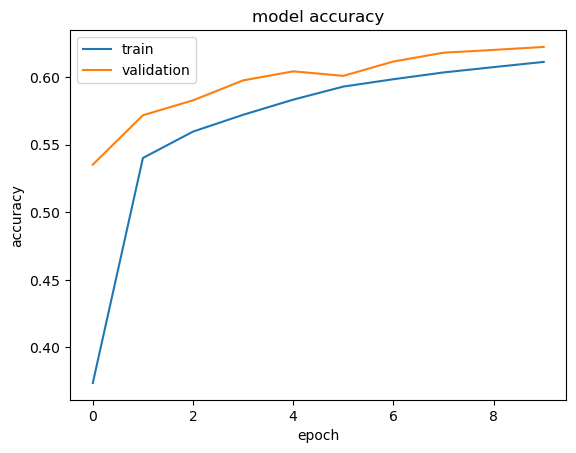

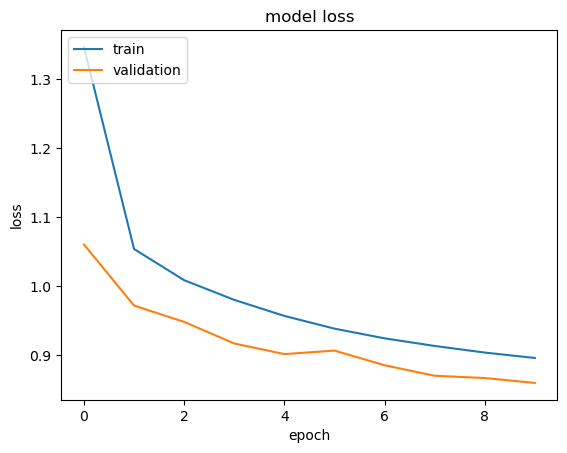

In [26]:
history = best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test

In [31]:
best_model.evaluate(x=x_test, y=y_test, batch_size=None,verbose=1,sample_weight=None)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 502s 321ms/step - acc: 0.5916 - loss: 0.9324


[0.9032521843910217, 0.6034600138664246]

In [4]:
from tensorflow.keras.models import load_model


In [13]:
model = load_model('Model_10epoch_glove_yelp.keras', custom_objects={'AttentionLayer': AttentionLayer})

## Save Model